# Softmax fast approximations

Короче, выбрал этот странный mxnet т.к. там 1)очень простая предобработка (причем она есть для всех датасетов, стоит только поменять dataset_name) и 2)есть предобученные языковые модели на этих датасетах, так что можно не тратить время на обучение вообще - никаких gpu не надо

По сути тут все операции как в numpy (вместо np пиши nd и все)

Про gluonnlp & mxnet за 5 минут https://beta.mxnet.io/guide/crash-course/index.html

In [1]:
import warnings
warnings.filterwarnings('ignore')

import glob
import time
import math

import mxnet as mx
from mxnet import gluon, autograd
from mxnet.gluon.utils import download
from mxnet import ndarray as nd

import gluonnlp as nlp
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
num_gpus = 0
context = [mx.gpu(i) for i in range(num_gpus)] if num_gpus else mx.cpu()
log_interval = 200

In [3]:
batch_size = 20 #* len(context)
lr = 20
epochs = 3
bptt = 35
grad_clip = 0.25

In [4]:
dataset_name = 'wikitext-2'
train_dataset, val_dataset, test_dataset = [
    nlp.data.WikiText2(
        segment=segment, bos=None, eos='<eos>', skip_empty=False)
    for segment in ['train', 'val', 'test']
]

vocab = nlp.Vocab(
    nlp.data.Counter(train_dataset), padding_token=None, bos_token=None)

bptt_batchify = nlp.data.batchify.CorpusBPTTBatchify(
    vocab, bptt, batch_size, last_batch='discard')
train_data, val_data, test_data = [
    bptt_batchify(x) for x in [train_dataset, val_dataset, test_dataset]
]

In [5]:
model_names = [
    'awd_lstm_lm_1150',
    'awd_lstm_lm_600',
    'standard_lstm_lm_1500',
    'standard_lstm_lm_650',
    'standard_lstm_lm_200',
#     'elmo_2x4096_512_2048cnn_2xhighway'
]
# model_name = 'standard_lstm_lm_200'
# model, vocab = nlp.model.get_model(model_name, vocab=vocab, 
#                                    dataset_name=dataset_name, pretrained=True, 
#                                    ctx=context)
# original_decoder = model.decoder
# print(model)
# print(vocab)
models = dict((name, nlp.model.get_model(name, vocab=vocab, 
                                         dataset_name=dataset_name, pretrained=True, 
                                         ctx=context)[0]) for name in model_names)

# model.initialize(mx.init.Xavier(), ctx=context)

# trainer = gluon.Trainer(model.collect_params(), 'sgd', {
#     'learning_rate': lr,
#     'momentum': 0,
#     'wd': 0
# })
loss = gluon.loss.SoftmaxCrossEntropyLoss()

In [6]:
for (name, model) in models.items():
    print(name)
    print(model)
    print(model.collect_params().keys())
    print()

awd_lstm_lm_1150
AWDRNN(
  (embedding): HybridSequential(
    (0): Embedding(33278 -> 400, float32)
    (1): Dropout(p = 0.65, axes=(0,))
  )
  (encoder): Sequential(
    (0): LSTM(400 -> 1150, TNC)
    (1): LSTM(1150 -> 1150, TNC)
    (2): LSTM(1150 -> 400, TNC)
  )
  (decoder): HybridSequential(
    (0): Dense(400 -> 33278, linear)
  )
)
odict_keys(['awdrnn0_hybridsequential0_embedding0_weight', 'awdrnn0_sequential0_lstm0_l0_i2h_weight', 'awdrnn0_sequential0_lstm0_l0_h2h_weight', 'awdrnn0_sequential0_lstm0_l0_i2h_bias', 'awdrnn0_sequential0_lstm0_l0_h2h_bias', 'awdrnn0_sequential0_lstm1_l0_i2h_weight', 'awdrnn0_sequential0_lstm1_l0_h2h_weight', 'awdrnn0_sequential0_lstm1_l0_i2h_bias', 'awdrnn0_sequential0_lstm1_l0_h2h_bias', 'awdrnn0_sequential0_lstm2_l0_i2h_weight', 'awdrnn0_sequential0_lstm2_l0_h2h_weight', 'awdrnn0_sequential0_lstm2_l0_i2h_bias', 'awdrnn0_sequential0_lstm2_l0_h2h_bias', 'awdrnn0_hybridsequential0_embedding0_bias'])

awd_lstm_lm_600
AWDRNN(
  (embedding): HybridSeq

In [7]:
def detach(hidden):
    if isinstance(hidden, (tuple, list)):
        hidden = [detach(i) for i in hidden]
    else:
        hidden = hidden.detach()
    return hidden

def evaluate(model, data_source, batch_size, ctx, loss=loss, max_steps=1000//batch_size):
    total_L = 0.0
    total_time = 0.0
    ntotal = 0
    hidden = model.begin_state(
        batch_size=batch_size, func=mx.nd.zeros, ctx=ctx)
    for i, (data, target) in enumerate(data_source):
        data = data.as_in_context(ctx)
        target = target.as_in_context(ctx)
        t_begin = time.time()
        output, hidden = model(data, hidden)
        output.wait_to_read()
        single_t = time.time() - t_begin
        hidden = detach(hidden)
        if loss is not None:
            L = loss(output.reshape(-3, -1), target.reshape(-1))
            total_L += mx.nd.sum(L).asscalar()
        total_time += single_t
        ntotal += target.reshape(-1).size
        if i > max_steps:
            break
#         print(f'curr loss = {total_L/ntotal:.2f}, '
#               'perplexity = {np.exp(total_L/ntotal):.2f}, '
#               'time = {total_time/ntotal:.7f}')
    return total_L / ntotal, total_time / ntotal

def make_report(prefix, L, t):
    print(f'{prefix} loss: {L:.2f}, ppl: {np.exp(L):.2f} time: {t:.7f}')
    
def evaluate_and_log(model, data_source, batch_size, ctx, loss=loss, prefix=""):
    avg_L, avg_t = evaluate(model, test_data, batch_size, context, loss=loss)
    make_report(prefix, avg_L, avg_t)
    return avg_L, avg_t

In [8]:
original_decoder = None
model = models['standard_lstm_lm_200']

In [29]:
%%time
if original_decoder is None:
    original_decoder = model.decoder
else:
    model.decoder = original_decoder
model.hybridize(active=False)
evaluate_and_log(model, test_data, batch_size, context, loss=loss)

 loss: 4.62, ppl: 101.78 time: 0.0001707
CPU times: user 23.6 s, sys: 623 ms, total: 24.2 s
Wall time: 15 s


In [10]:
class CELoss(gluon.loss.Loss):
    def __init__(self, axis=-1, sparse_label=True, from_logits=False, weight=None,
                 batch_axis=0, **kwargs):
        super(CELoss, self).__init__(weight, batch_axis, **kwargs)
        self._axis = axis
        self._sparse_label = sparse_label
        self._from_logits = from_logits

    def hybrid_forward(self, F, pred, label, sample_weight=None):
        EPS = 1e-12  # affects loss strongly!!!
        log_pred = F.log(F.clip(pred, EPS, 1-EPS))
        loss = -F.pick(log_pred, label, axis=self._axis, keepdims=True)
        return F.mean(loss, axis=self._batch_axis, exclude=True)

In [11]:
def get_last_layer_weight_and_bias(model):
    params = model.collect_params()
    W_suffix = '_hybridsequential0_embedding0_weight'
    b_suffix = '_hybridsequential0_embedding0_bias'
    W, b = None, None
    for param_key in params.keys():
        if param_key.endswith(W_suffix):
#             print('reading weight from', param_key)
            assert W is None
            W = params[param_key].data().asnumpy()
        elif param_key.endswith(b_suffix):
#             print('reading bias from', param_key)
            assert b is None
            b = params[param_key].data().asnumpy()
    assert W is not None and b is not None, params.keys()
    return W, b

def get_last_layer_svd_and_b(model):
    W, b = get_last_layer_weight_and_bias(model)
    U, Sigma, V_t = np.linalg.svd(W, full_matrices=False)
    return (U, Sigma, V_t), b

def create_decoder(model, preview_W=10, full_view_N=100, rough_approximation=False):
    svd_decomposition_W, b = get_last_layer_svd_and_b(model)
    
    new_decoder = gluon.nn.HybridSequential()
    new_decoder.add(
        SVDSoftmax(
            svd_decomposition_W, b, 
            preview_W=preview_W, 
            full_view_N=full_view_N,
            rough_approximation=rough_approximation))
    new_decoder.initialize()
    return new_decoder

def with_sm_decoder(model, preview_W=10, full_view_N=100, return_full=False):
    svd_decomposition_W, b = get_last_layer_svd_and_b(model)
    
    new_decoder = gluon.nn.HybridSequential()
    new_decoder.add(model.decoder[0])
    new_decoder.add(Softmax())
    new_decoder.initialize()
    return new_decoder

In [24]:
class Softmax(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(Softmax, self).__init__(**kwargs)

    def hybrid_forward(self, F, x):
        return F.softmax(x, axis=-1)

class SVDSoftmax(gluon.HybridBlock):
    def __init__(self, svd_decomposition, bias, preview_W=10, full_view_N=100, 
                 rough_approximation=False, activation=False, **kwargs):
        super(SVDSoftmax, self).__init__(**kwargs)
        U, Sigma, V_t = svd_decomposition
        B = U.dot(np.diag(Sigma))
        self.preview_W = preview_W
        self.full_view_N = min(full_view_N, B.shape[0])
        self.num_features_in = V_t.shape[0]
        self.num_classes = B.shape[0]
        self.rough_approximation = rough_approximation
        self.with_activation = activation
        with self.name_scope():
            self.B = self.params.get('B',
                                      shape=B.shape,
                                      init=mx.init.Constant(B.tolist()),
                                      differentiable=False)
            self.V_t = self.params.get('V_t', 
                                       shape=V_t.shape, 
                                       init=mx.init.Constant(V_t.tolist()),
                                       differentiable=False)
            self.bias = self.params.get('bias', 
                                        shape=bias.shape, 
                                        init=mx.init.Constant(bias.tolist()), 
                                        differentiable=False)

    def hybrid_forward(self, F, x, B, V_t, bias):
        x_shape = F.shape_array(x)
        # now x is strictly 3d... very sad but there is no conditional operation as tf.cond
        bs = batch_size
        tm = bptt
        x_2d = F.reshape(x, shape=(-3, -1))

        h = F.FullyConnected(x_2d, weight=V_t, no_bias=True, num_hidden=self.num_features_in, flatten=False)
        h_preview = F.slice_axis(h, axis=-1, begin=0, end=self.preview_W)  # h[:, :self.preview_W]
        B_preview = F.slice_axis(B, axis=1, begin=0, end=self.preview_W)  # B[:, :self.preview_W]
        z_preview = F.FullyConnected(h_preview, weight=B_preview, bias=bias,
                                     no_bias=False, num_hidden=self.num_classes, flatten=False)
        if self.rough_approximation:
            if self.with_activation:
                z_preview = F.softmax(z_preview, axis=-1)
            return F.reshape(z_preview, shape=(bs, tm, self.num_classes))
        
        best_indices = F.topk(z_preview, axis=-1, ret_typ='indices', k=self.full_view_N)
        
        # this is slower
        # Bs = F.stack(*[B[best_indices[i]] for i in range(bs*tm)], axis=0)
        # b_s = F.stack(*[bias[best_indices[i]] for i in range(bs*tm)], axis=0)
        # best_logits = F.squeeze(F.batch_dot(Bs, nd.expand_dims(h, axis=-1)), axis=-1) + b_s
        
        # F.gather_nd(B, best_indices[i]) == B[best_indices[i], :]
        best_logits = [
            F.dot(F.gather_nd(B, best_indices[i].reshape((1,-1))), h[i]) + bias[best_indices[i]]
            for i in range(bs * tm)
        ]
        
        z = z_preview
        
        # вот тут у чуваков map_fn хз может так и быстрее, но в mxnet вроде нет такого
#         ind0 = F.arange(0, bs*tm, repeat=self.full_view_N, dtype=np.int)
#         ind1 = best_indices
#         z[ind0, ind1] = best_logits
        for i in range(bs * tm):
            z[i, best_indices[i]] = best_logits[i]
            
        if self.with_activation:
            z = F.softmax(z, axis=-1)
        return F.reshape(z, shape=(bs, tm, self.num_classes))

In [31]:
%%time
model.decoder = original_decoder
model.decoder = create_decoder(model, preview_W=25, full_view_N=3200, rough_approximation=True)
model.hybridize(active=False)
evaluate_and_log(model, test_data, batch_size, context, loss=loss)

 loss: 5.34, ppl: 208.83 time: 0.0001366
CPU times: user 17.5 s, sys: 1.13 s, total: 18.6 s
Wall time: 15.2 s


In [32]:
%%time
model.decoder = original_decoder
model.decoder = create_decoder(model, preview_W=25, full_view_N=3200, rough_approximation=False)
model.hybridize(active=False)
evaluate_and_log(model, test_data, batch_size, context, loss=loss)

 loss: 4.63, ppl: 102.45 time: 0.0028233
CPU times: user 1min 49s, sys: 36.9 s, total: 2min 26s
Wall time: 1min 52s


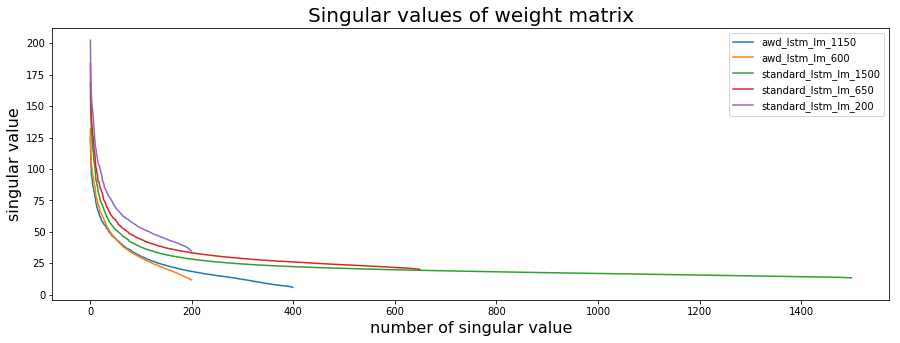

In [23]:
plt.figure(figsize=(15,5))
for model_name, model in models.items():
    svd, b = get_last_layer_svd_and_b(model)
    s = svd[1]
    plt.plot(s, label=model_name)
plt.xlabel(f"number of singular value", fontsize=16)
plt.ylabel(f"singular value", fontsize=16)
plt.title(f"Singular values of weight matrix", fontsize=20)
plt.legend()
plt.show()

In [12]:
model.decoder = original_decoder

In [33]:
%%time
model.decoder = original_decoder
model.hybridize(active=False)
orig_l, orig_t = evaluate_and_log(model, test_data, batch_size, context, loss=loss)

 loss: 4.62, ppl: 101.78 time: 0.0001720
CPU times: user 23.5 s, sys: 649 ms, total: 24.2 s
Wall time: 15.1 s


In [35]:
import tqdm

In [43]:
%%time
ts, ls = [], []
full_view_N = 3200
preview_Ws = [1, 5, 10, 15, 30, 50, 70, 100, 120, 150, 200]
for preview_W in tqdm.tqdm(preview_Ws):
    model.decoder = original_decoder
    model.decoder = create_decoder(model, preview_W=preview_W, full_view_N=full_view_N)
    model.hybridize(active=False)
    l, t = evaluate(model, test_data, batch_size, context, loss=loss)
#     l, t = evaluate_and_log(model, test_data, batch_size, context, loss=None)
    
#     model.decoder = original_decoder
#     model.decoder = create_decoder(model, preview_W=preview_W, full_view_N=full_view_N, return_full=False)
#     _, t = evaluate_and_log(model, test_data, batch_size, context, loss=None)
    
    ls.append(l)
    ts.append(t)

100%|██████████| 11/11 [20:31<00:00, 114.65s/it]

CPU times: user 20min 13s, sys: 6min 25s, total: 26min 39s
Wall time: 20min 31s


Text(0.5, 1.0, 'Loss for N=3200')

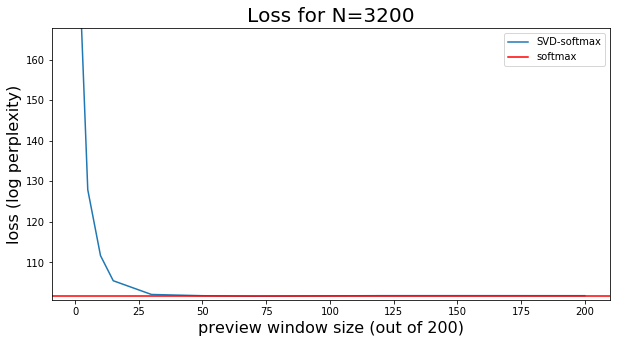

In [45]:
plt.figure(figsize=(10,5))
plt.plot(preview_Ws, np.exp(ls), label="SVD-softmax")
plt.axhline(y=np.exp(orig_l), color='red', label="softmax")
plt.xlabel("preview window size (out of 200)", fontsize=16)
plt.ylabel("loss (log perplexity)", fontsize=16)
plt.ylim((np.exp(orig_l-0.01), np.exp(orig_l+0.5)))
plt.legend()
plt.title("Loss for N=3200", fontsize=20)

Text(0.5, 1.0, 'Token prediction time')

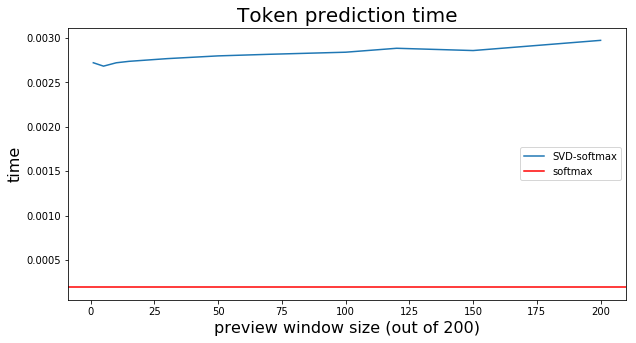

In [47]:
plt.figure(figsize=(10,5))
plt.plot(preview_Ws, ts, label="SVD-softmax")
plt.axhline(y=0.00019, color='red', label="softmax")
plt.xlabel("preview window size (out of 200)", fontsize=16)
plt.ylabel("time", fontsize=16)
plt.legend()
plt.title("Token prediction time", fontsize=20)

So we select found it reasonable choise to take preview window size = 1/8 of hidden dimension size (D)

In [48]:
preview_W = 25
for full_view_N in [1, 5, 10, 20, 50] + list(range(100, 4000, 300)) + list(range(4000, 32000, 2500)):
    model.decoder = original_decoder
    model.decoder = create_decoder(model, preview_W=preview_W, full_view_N=full_view_N)
    model.hybridize(active=False)
    l, t = evaluate(model, test_data, batch_size, context, loss=loss)

KeyboardInterrupt: 

In [32]:
def train(model, train_data, val_data, test_data, epochs, lr):
    best_val = float("Inf")
    start_train_time = time.time()
    parameters = model.collect_params().values()
    for epoch in range(epochs):
        total_L = 0.0
        start_epoch_time = time.time()
        start_log_interval_time = time.time()
        hiddens = [model.begin_state(batch_size//len(context), func=mx.nd.zeros, ctx=ctx)
                   for ctx in context]
        for i, (data, target) in enumerate(train_data):
            data_list = gluon.utils.split_and_load(data, context,
                                                   batch_axis=1, even_split=True)
            target_list = gluon.utils.split_and_load(target, context,
                                                     batch_axis=1, even_split=True)
            hiddens = detach(hiddens)
            L = 0
            Ls = []
            with autograd.record():
                for j, (X, y, h) in enumerate(zip(data_list, target_list, hiddens)):
                    output, h = model(X, h)
                    batch_L = loss(output.reshape(-3, -1), y.reshape(-1,))
                    L = L + batch_L.as_in_context(context[0]) / (len(context) * X.size)
                    Ls.append(batch_L / (len(context) * X.size))
                    hiddens[j] = h
            L.backward()
            grads = [p.grad(x.context) for p in parameters for x in data_list]
            gluon.utils.clip_global_norm(grads, grad_clip)

            trainer.step(1)

            total_L += sum([mx.nd.sum(l).asscalar() for l in Ls])

            if i % log_interval == 0 and i > 0:
                cur_L = total_L / log_interval
                print('[Epoch %d Batch %d/%d] loss %.2f, ppl %.2f, '
                      'throughput %.2f samples/s'%(
                    epoch, i, len(train_data), cur_L, math.exp(cur_L),
                    batch_size * log_interval / (time.time() - start_log_interval_time)))
                total_L = 0.0
                start_log_interval_time = time.time()

        mx.nd.waitall()

        print('[Epoch %d] throughput %.2f samples/s'%(
                    epoch, len(train_data)*batch_size / (time.time() - start_epoch_time)))
        val_L, val_time = evaluate(model, val_data, batch_size, context[0])
        print('[Epoch %d] time cost %.2fs, valid loss %.2f, valid ppl %.2f'%(
            epoch, time.time()-start_epoch_time, val_L, math.exp(val_L)))

        if val_L < best_val:
            best_val = val_L
            test_L, test_time = evaluate(model, test_data, batch_size, context[0])
            model.save_parameters('{}_{}-{}.params'.format(model_name, dataset_name, epoch))
            print('test loss %.2f, test ppl %.2f, test time %.2f'%(
                test_L, math.exp(test_L), test_time))
        else:
            lr = lr*0.25
            print('Learning rate now %f'%(lr))
            trainer.set_learning_rate(lr)

    print('Total training throughput %.2f samples/s'%(
                            (batch_size * len(train_data) * epochs) /
                            (time.time() - start_train_time)))

In [7]:
train(model, train_data, val_data, test_data, epochs, lr)

[Epoch 0 Batch 200/2983] loss 7.66, ppl 2129.11, throughput 281.65 samples/s
[Epoch 0 Batch 400/2983] loss 6.75, ppl 853.92, throughput 286.11 samples/s
[Epoch 0 Batch 600/2983] loss 6.34, ppl 568.07, throughput 286.57 samples/s
[Epoch 0 Batch 800/2983] loss 6.18, ppl 483.26, throughput 286.67 samples/s
[Epoch 0 Batch 1000/2983] loss 6.05, ppl 422.96, throughput 286.33 samples/s
[Epoch 0 Batch 1200/2983] loss 5.97, ppl 391.82, throughput 286.72 samples/s
[Epoch 0 Batch 1400/2983] loss 5.87, ppl 352.51, throughput 286.17 samples/s
[Epoch 0 Batch 1600/2983] loss 5.86, ppl 351.89, throughput 286.47 samples/s
[Epoch 0 Batch 1800/2983] loss 5.70, ppl 299.67, throughput 286.51 samples/s
[Epoch 0 Batch 2000/2983] loss 5.67, ppl 289.43, throughput 286.45 samples/s
[Epoch 0 Batch 2200/2983] loss 5.57, ppl 261.92, throughput 283.67 samples/s
[Epoch 0 Batch 2400/2983] loss 5.58, ppl 264.64, throughput 287.07 samples/s
[Epoch 0 Batch 2600/2983] loss 5.56, ppl 259.61, throughput 286.79 samples/s
[E